#  Evaluate whether older planes suffer more delays on a year-to-year basis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

## General formula with explanation using 1999 as a template

#### Reading the plane data csv and the removing any NaN values 
#### We proceed to convert the year column into a datetime for easier manipulation in the future 
#### Lastly, we filter to keep planes that are manufactured 1999 and before. This changes with every year 

In [3]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  #Firstly, we are looking into the year column as the Issuedate column has too many NaN Values for accurate data visualiation. Secondly, we are use drop.na to remove all the NaN values in 'year'


# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y') # pd.to_datetime helps to convert the data in 'year' into a pandas datetime object instead of a series or other datatypes for easier manuipulation in the future. the format = %Y is to make sure the year are only in the 4 digit year 

# Filter out planes manufactured before 1999
plane_data = plane_data[plane_data['year'].dt.year <= 1999] #dt means datatype. we are filtering out planes after 1999

#### We find the age of planes at our specific interested year 

In [4]:
# Calculating the age of planes by 1999
plane_data['AgeAt1999'] = 1999 - plane_data['year'].dt.year # the year input changes with which year we are looking at 

In [5]:
print(plane_data[['year', 'AgeAt1999']])

           year  AgeAt1999
35   1998-01-01          1
36   1986-01-01         13
37   1999-01-01          0
38   1998-01-01          1
39   1999-01-01          0
...         ...        ...
5022 1991-01-01          8
5024 1992-01-01          7
5026 1992-01-01          7
5027 1998-01-01          1
5028 1992-01-01          7

[2301 rows x 2 columns]


#### We first define the threshold_age (this threshold_age changes based on plane age at different years)
#### Then, we create a new column called PlaneCategory to catergorise the planes age as either older or younger based on the threshold

In [6]:
# Define the threshold age where usually > 20 is considered older but since there are little to no planes > 20, our threshold age will differ
threshold_age = 11 # this threshold_age will change with varying years 

#Create a new column 'PlaneCategory' to categorise planes as 'Older' or 'Younger'
plane_data['PlaneCategory'] = 'Younger'  # Initially set all planes as 'Younger' for easier coding classification later
plane_data.loc[plane_data['AgeAt1999'] >= threshold_age, 'PlaneCategory'] = 'Older' # loc means locating.

In [7]:
print(plane_data) # To help observe how out end manipulation looks like 

     tailnum                 type                   manufacturer  issue_date  \
35    N102UW          Corporation               AIRBUS INDUSTRIE  05/26/1999   
36    N10323          Corporation                         BOEING  07/01/1997   
37    N103US          Corporation               AIRBUS INDUSTRIE  06/18/1999   
38    N104UA          Corporation                         BOEING  01/26/1998   
39    N104UW          Corporation               AIRBUS INDUSTRIE  07/02/1999   
...      ...                  ...                            ...         ...   
5022  N996DL          Corporation  MCDONNELL DOUGLAS AIRCRAFT CO  02/27/1992   
5024  N997DL          Corporation  MCDONNELL DOUGLAS AIRCRAFT CO  03/11/1992   
5026  N998DL          Corporation  MCDONNELL DOUGLAS CORPORATION  04/02/1992   
5027  N999CA  Foreign Corporation                       CANADAIR  07/09/2008   
5028  N999DN          Corporation  MCDONNELL DOUGLAS CORPORATION  04/02/1992   

            model status            air

#### Read the interested year csv and filter out the diverted and cancelled flights 
#### Then, we rename the tailnum column in plane_data to TailNum so that it matches with that same column in the year csv to effectively merge them together.  (We cannot merge plane_data and year csv if their columns have different captialised letters even though the names are the same)

In [8]:
df= pd.read_csv("1999.csv")

In [9]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Rename plane_data tailnum column into TailNum to be the same as the year's column name
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merge the two DataFrames via the 'TailNum' column
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

### The following code will be trying to visualise / plot bar graph to show mean Delay between older and younger planes. We don not remove ontime or earlier flights as we are firstly viewing the older and younger planes delay in a big picture 

#### To calculate delay, we add the ArrDelay and DepDelay together to create a Delay column
#### From the merged_data, we separate the younger and older planes into their own dataframe 
#### In each of the younger and older planes dataframe we clean it to remove NaN values in the Delay column. Afterwards, we group to make sure the planes are in their respective category and then we get the mean of the newly made Delay column

In [10]:
# Calculating total delays , which is arrival delay to the airport and the departure delay to leave the airport

merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separating the older and younger planes from the merged_data 
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cleaning up the data to make sure theres no NaN values
older_planes_cleaned = older_planes.dropna(subset=['Delay']) 
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate the average delays with older and younger planes
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() # agg means aggregate and reset.index() is resetting the data back into a column 
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


#### Plotting a bar graph for both younger and older planes in 1 diagram to compare their avg_delays. The average delays labelled are in minutes 

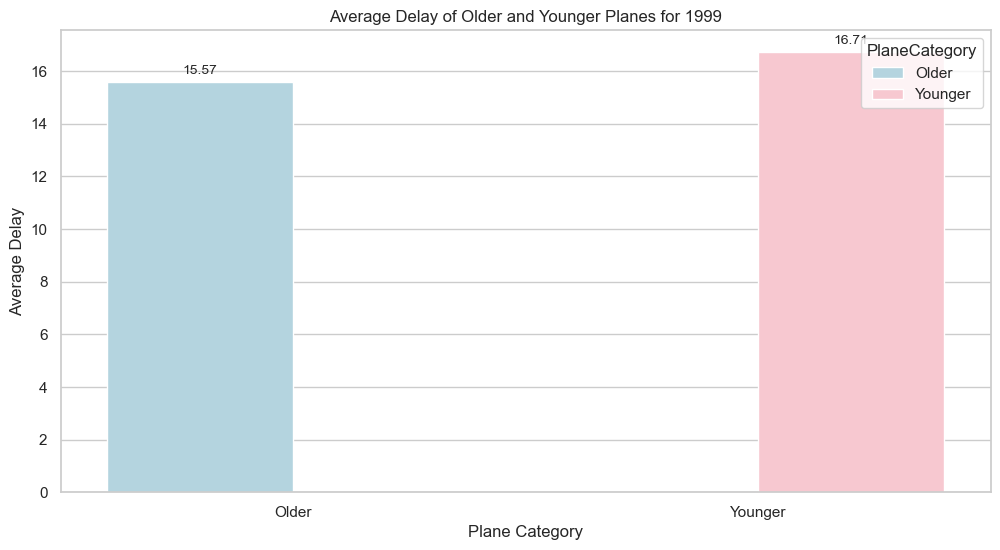

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  15.571381
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  16.710428


In [11]:
# Ploting a bar graph for each younger_avgdelays and older_avgdelays separately into one diagram

# Setting up the parameter 
rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 


# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays]) # Joining the older_avgdelays and younger_avgdelays into 1 to easily plot the two different variables into a single diagram with their own bar graph

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    
# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 1999')

# Show the plot
plt.show()

# Print out the average delays for easier visualisation 
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


#### We can oberseve that overall Younger planes experiences slightly higher delays and this could be due to many reasons like  having lower numbers of ontime or earlier flights or the when younger planes depart or arrive early, they are not as early as older planes 

### The following codes will be trying to narrow down the reasonings for the above results. Hence, we will be identifying percentage of delayed flights between older and younger planes 

### In this section, we will specifically be looking at delayed flights (i.e Delay ( Arrival + departure ) > 0 ) 

### To keep consistency, we chose to look at specifically Delay > 0 to count as a delayed flight as not only does it represent the full delay a flight might incurr during its route, but in our previous average Delay graph, it is also showing the full delay per route but without removing potential ontime or earlier flights

#### We first find the total number of delayed flights in each category and then we divide it by the number of rows in older_planes_cleaned ( contains ontime , earlier and delayed flights) and we multiply it by 100 to get the percentages and the %s are printed for easier viewing 

In [12]:
# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

print("Percentage of delayed flights in older planes :", older_planes_with_delayed_flights)
print("Percentage of delayed flights in younger planes :", younger_planes_with_delayed_flights)


Percentage of delayed flights in older planes : 46.87098956518174
Percentage of delayed flights in younger planes : 49.523407354848025


#### Plotting a bar graph to visualise the differences in percentages between older and younger planes

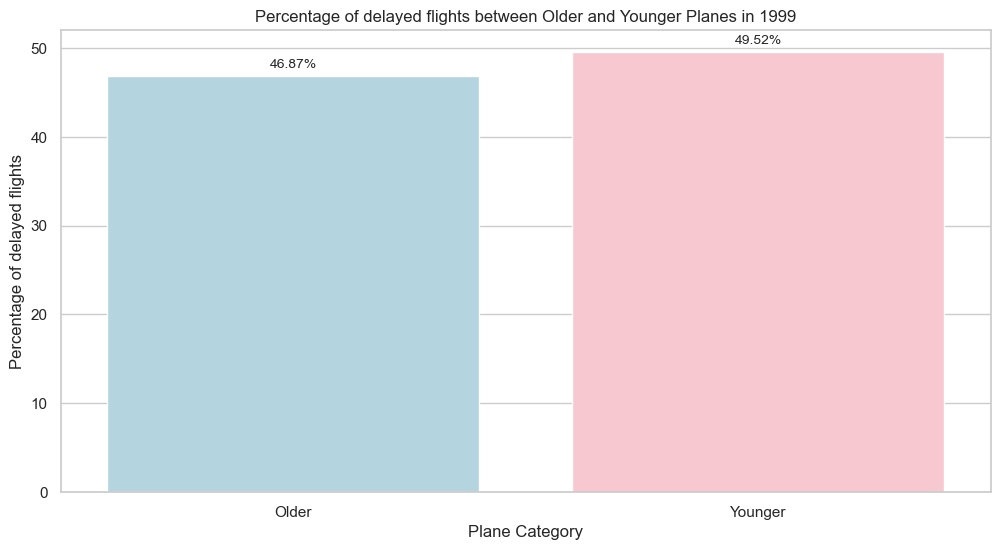

In [13]:
# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 1999')

# Show the plot
plt.show()

#### From the graph, young planes experiences roughly 3% more delayed flights than older planes, thus also meaning that they have around 3% lesser ontime and earlier flights. Thus, explains why in the bar graph showing the overall average delay, younger planes have a higher value 

### Repeating these codes for the next 9 years of data, only changing the year input and recalibrate the threshold_age

### 2000

In [3]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')


# Filter out planes manufactured after 2000
plane_data = plane_data[plane_data['year'].dt.year <= 2000]

#calculating the age
plane_data['AgeAt2000'] = 2000 - plane_data['year'].dt.year
print(plane_data[['year', 'AgeAt2000']])

           year  AgeAt2000
35   1998-01-01          2
36   1986-01-01         14
37   1999-01-01          1
38   1998-01-01          2
39   1999-01-01          1
...         ...        ...
5022 1991-01-01          9
5024 1992-01-01          8
5026 1992-01-01          8
5027 1998-01-01          2
5028 1992-01-01          8

[2642 rows x 2 columns]


In [15]:
df = pd.read_csv("2000.csv")

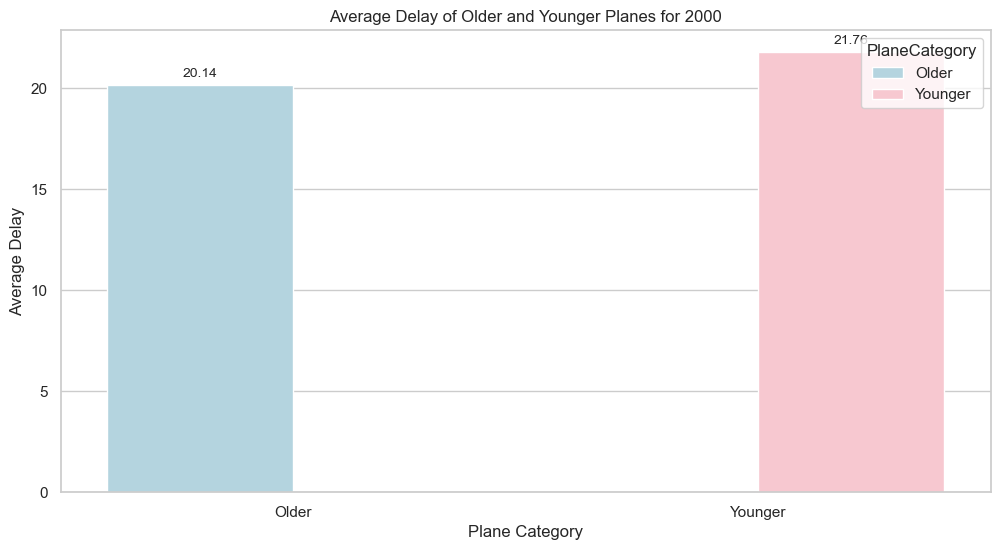

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  20.141359
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  21.764228


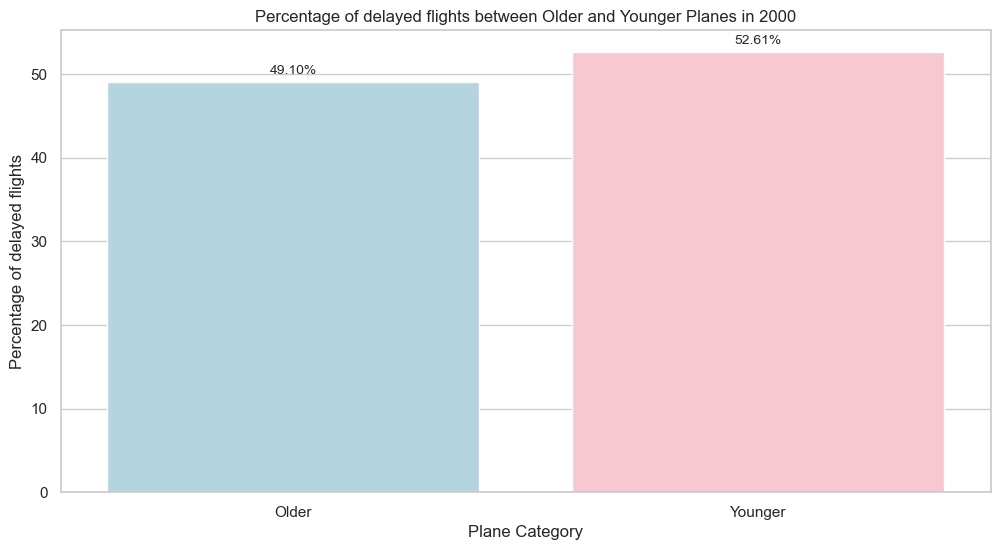

In [16]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 11

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2000'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2000')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2000')

# Show the plot
plt.show()

#### In the average delay graph, younger planes experiences higher delays and this is backed by the percentage of delayed flights graph where more than half of the younger planes experiences delays
#### The % graph also shows that the younger planes has about 4% more delayed flights than the older

### 2001

In [17]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')


# Filter out planes manufactured after 2001
plane_data = plane_data[plane_data['year'].dt.year <= 2001]

#calculating the age
plane_data['AgeAt2001'] = 2001 - plane_data['year'].dt.year
print(plane_data[['year', 'AgeAt2001']])

           year  AgeAt2001
35   1998-01-01          3
36   1986-01-01         15
37   1999-01-01          2
38   1998-01-01          3
39   1999-01-01          2
...         ...        ...
5022 1991-01-01         10
5024 1992-01-01          9
5026 1992-01-01          9
5027 1998-01-01          3
5028 1992-01-01          9

[3031 rows x 2 columns]


In [18]:
df = pd.read_csv("2001.csv",  encoding='iso-8859-1') # encoding is done to prevent an unicodeerror from occuring. Only applies to 2001 and 2002

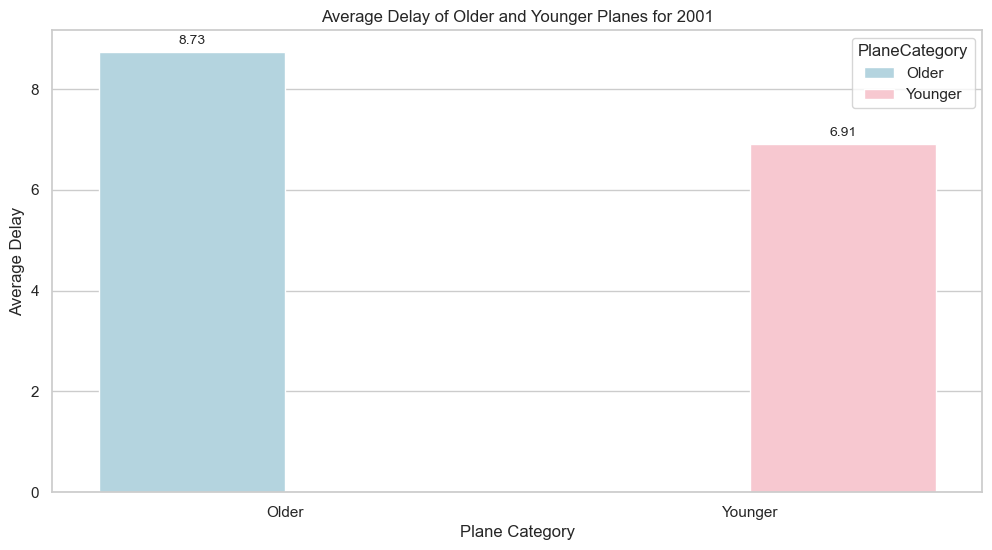

Average Delay of Older Planes:   PlaneCategory     mean
0         Older  8.72745
Average Delay of Younger Planes:   PlaneCategory      mean
0       Younger  6.905527


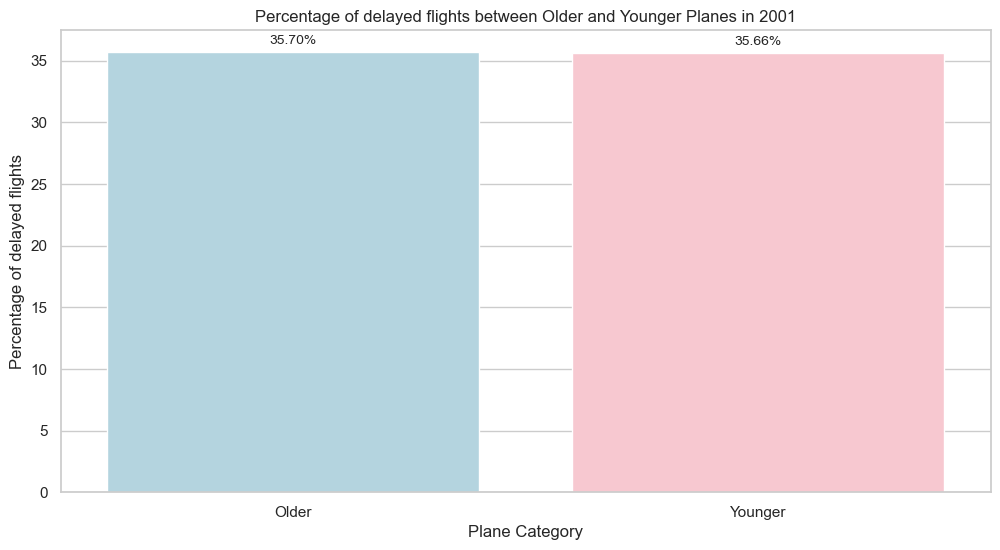

In [19]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 11

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2001'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2001')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2001')

# Show the plot
plt.show()

#### The average delay graph shows that older planes experiences higher delay, supported by the % graph that shows that older planes has a higher % of delayed flights
#### However, in the % graph, older and younger planes only have a 0.04% difference but in the average delay graph older planes has almost 2 more minutes in average delay than younger planes. As such, a more prominent reasoning for older planes having higher average delay timings could be either having less ontime flights or the values representing earlier flights in older planes are not as low as the ones in younger planes

### 2002

In [4]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')


# Filter out planes manufactured after 2002
plane_data = plane_data[plane_data['year'].dt.year <= 2002]

#calculating the age
plane_data['AgeAt2002'] = 2002 - plane_data['year'].dt.year
print(plane_data[['year', 'AgeAt2002']])

           year  AgeAt2002
35   1998-01-01          4
36   1986-01-01         16
37   1999-01-01          3
38   1998-01-01          4
39   1999-01-01          3
...         ...        ...
5024 1992-01-01         10
5025 2002-01-01          0
5026 1992-01-01         10
5027 1998-01-01          4
5028 1992-01-01         10

[3337 rows x 2 columns]


In [5]:
df = pd.read_csv("2002.csv",  encoding='iso-8859-1') # encoding is done to prevent an unicodeerror from occuring. Only applies to 2001 and 2002

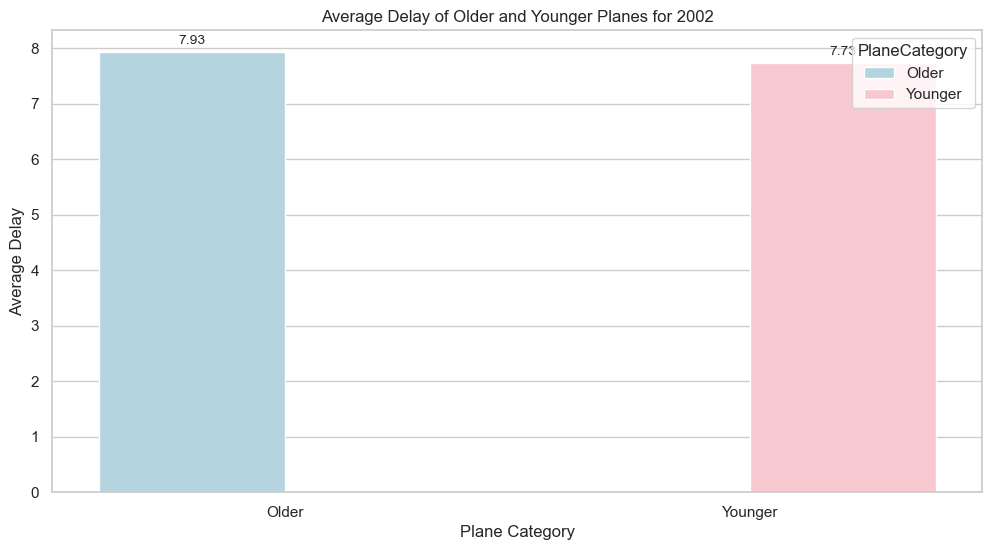

Average Delay of Older Planes:   PlaneCategory      mean
0         Older  7.925419
Average Delay of Younger Planes:   PlaneCategory      mean
0       Younger  7.727531


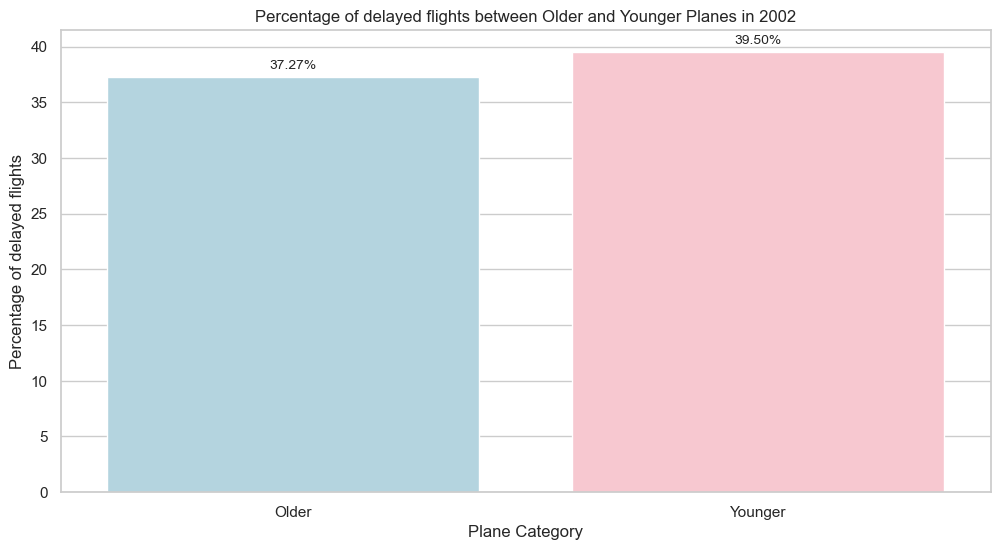

In [6]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 14

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2002'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2002')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2002')

# Show the plot
plt.show()

#### From the average delay graph, older planes has higher delay than younger. However, in the % graph, it shows that younger planes have a 4 higher % of delayed flights. 
#### This could mean that for younger planes, they have more ontime flights or the values for earlier flights are lower than the oens in older planes, hence brining downn younger planes average delays 

### 2003

In [9]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')

# Filter out planes manufactured after 2003
plane_data = plane_data[plane_data['year'].dt.year <= 2003]

#calculating the age
plane_data['AgeAt2003'] = 2003 - plane_data['year'].dt.year
print(plane_data[['year', 'AgeAt2003']])

           year  AgeAt2003
35   1998-01-01          5
36   1986-01-01         17
37   1999-01-01          4
38   1998-01-01          5
39   1999-01-01          4
...         ...        ...
5024 1992-01-01         11
5025 2002-01-01          1
5026 1992-01-01         11
5027 1998-01-01          5
5028 1992-01-01         11

[3603 rows x 2 columns]


In [7]:
df = pd.read_csv("2003.csv")

C:\Users\chongpl\AppData\Local\Temp\ipykernel_5272\2250118353.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("2003.csv.bz2")


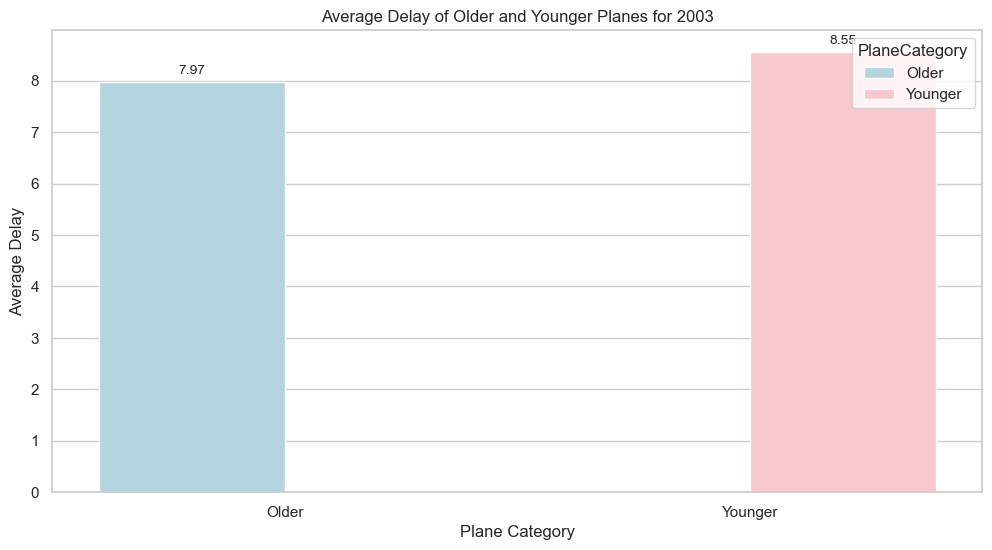

Average Delay of Older Planes:   PlaneCategory      mean
0         Older  7.971968
Average Delay of Younger Planes:   PlaneCategory      mean
0       Younger  8.554954


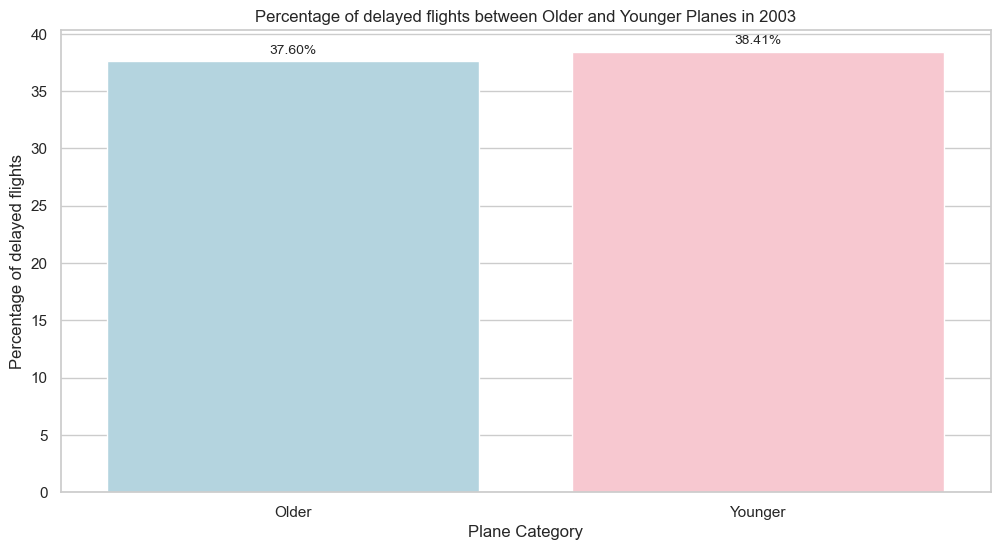

In [10]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 14

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2003'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2003')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2003')

# Show the plot
plt.show()

#### From average delay graph, younger planes experiences higher delays and is supported by the % graph where younger planes have higher % of delayed flights. 
#### In the % graph, younger planes have about 1% higher delayed flights and from the average delay graph, younger planes have about 1 minute more in average delays as well. Overall, these % and timings support each other

### 2004

In [11]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')

# Filter out planes manufactured after 2004
plane_data = plane_data[plane_data['year'].dt.year <= 2004]

#calculating the age
plane_data['AgeAt2004'] = 2004 - plane_data['year'].dt.year
print(plane_data[['year', 'AgeAt2004']])

           year  AgeAt2004
34   2004-01-01          0
35   1998-01-01          6
36   1986-01-01         18
37   1999-01-01          5
38   1998-01-01          6
...         ...        ...
5024 1992-01-01         12
5025 2002-01-01          2
5026 1992-01-01         12
5027 1998-01-01          6
5028 1992-01-01         12

[3843 rows x 2 columns]


In [12]:
df = pd.read_csv("2004.csv")

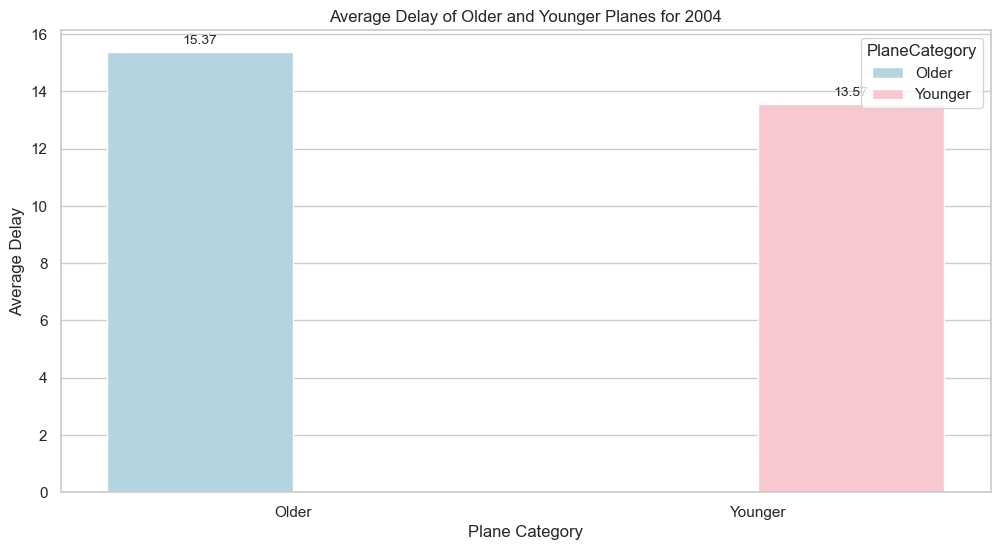

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  15.370454
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  13.566688


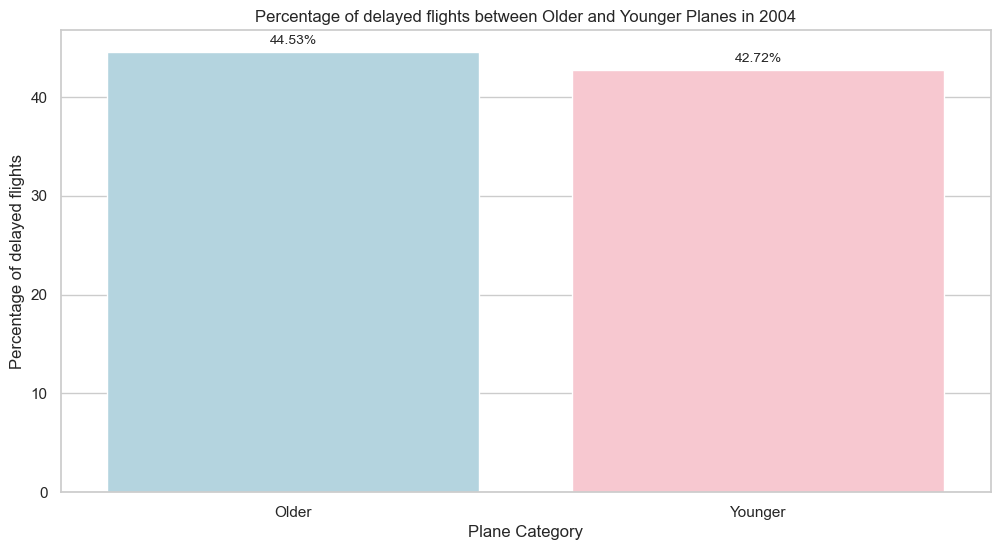

In [13]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 15

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2004'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2004')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2004')

# Show the plot
plt.show()

#### The average delay graph shows that older planes suffer more delays and is backed by the % graph where older planes have a higher % of delayed flights 

#### older planes has about a 2% higher delayed flights and it does correlate to older planes experiencing about 2 mins more average delays

### 2005

In [14]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Using the 'year' column we drop rows with missing or invalid values 
plane_data = plane_data[plane_data['year'] != 0]  

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')


# Filter out planes manufactured after 2005
plane_data = plane_data[plane_data['year'].dt.year <= 2005]

#calculating the age
plane_data['AgeAt2005'] = 2005 - plane_data['year'].dt.year
print(plane_data[['year', 'AgeAt2005']])

           year  AgeAt2005
34   2004-01-01          1
35   1998-01-01          7
36   1986-01-01         19
37   1999-01-01          6
38   1998-01-01          7
...         ...        ...
5024 1992-01-01         13
5025 2002-01-01          3
5026 1992-01-01         13
5027 1998-01-01          7
5028 1992-01-01         13

[4036 rows x 2 columns]


In [15]:
df = pd.read_csv("2005.csv")

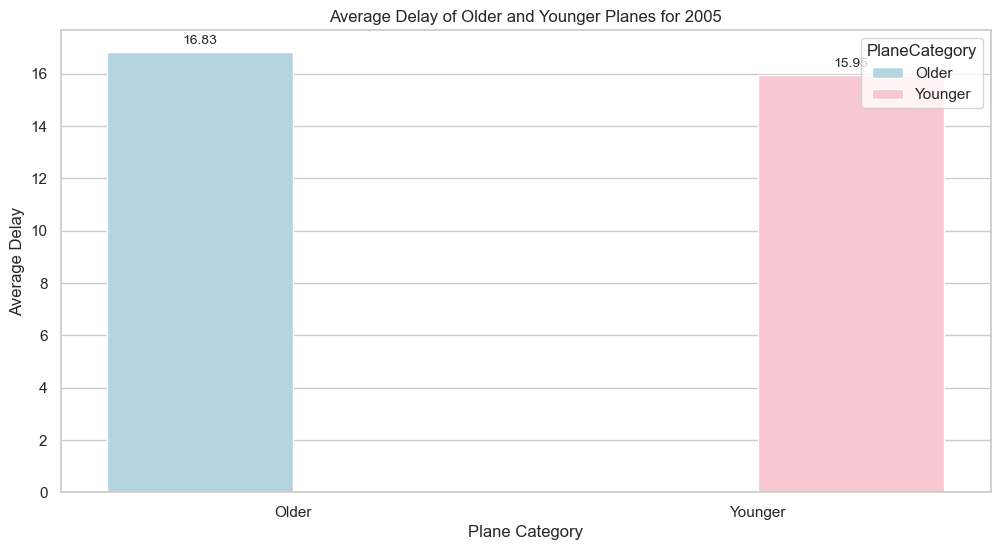

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  16.825782
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  15.952141


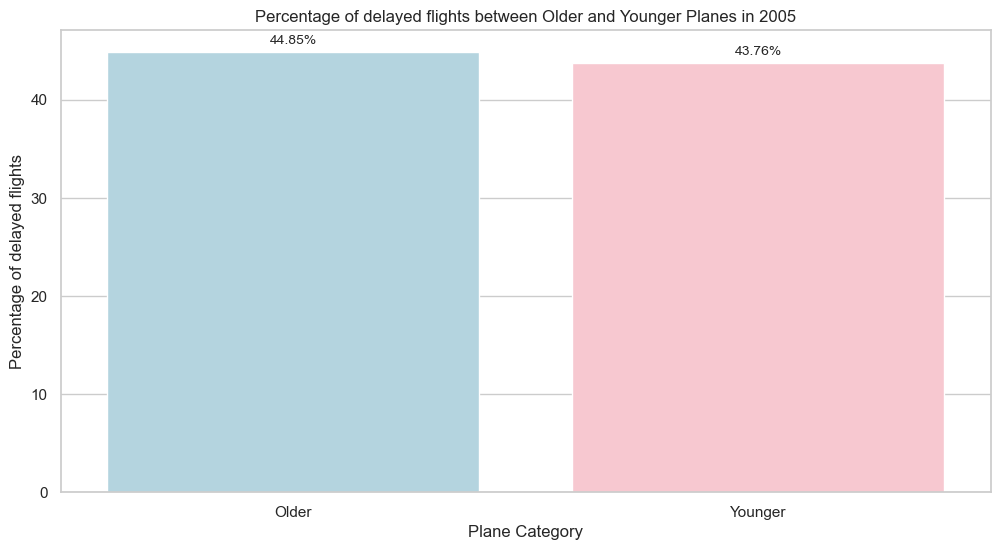

In [16]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 16

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2005'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2005')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2005')

# Show the plot
plt.show()

#### From the graph, older planes experiences higher average delay and this is backed by older planes also experiencing higher % of delayed flights as well
#### older planes has about a 1% higher delayed flights and it does correlate to older planes experiencing about 1 mins more average delays

### 2006

In [26]:
plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Filter out invalid values in the 'year' column
plane_data = plane_data[plane_data['year'] != 0]

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')

# Calculate the age of the planes at 2006
plane_data['AgeAt2006'] = 2006 - plane_data['year'].dt.year # 2007 to 2008, theres no need to print out anymore since we would contiue using the standard >20 years as a threshold

In [27]:
print(plane_data)


     tailnum                 type                   manufacturer  issue_date  \
34    N10156          Corporation                        EMBRAER  02/13/2004   
35    N102UW          Corporation               AIRBUS INDUSTRIE  05/26/1999   
36    N10323          Corporation                         BOEING  07/01/1997   
37    N103US          Corporation               AIRBUS INDUSTRIE  06/18/1999   
38    N104UA          Corporation                         BOEING  01/26/1998   
...      ...                  ...                            ...         ...   
5024  N997DL          Corporation  MCDONNELL DOUGLAS AIRCRAFT CO  03/11/1992   
5025  N998AT          Corporation                         BOEING  01/23/2003   
5026  N998DL          Corporation  MCDONNELL DOUGLAS CORPORATION  04/02/1992   
5027  N999CA  Foreign Corporation                       CANADAIR  07/09/2008   
5028  N999DN          Corporation  MCDONNELL DOUGLAS CORPORATION  04/02/1992   

            model status            air

In [28]:
df = pd.read_csv("2006.csv")

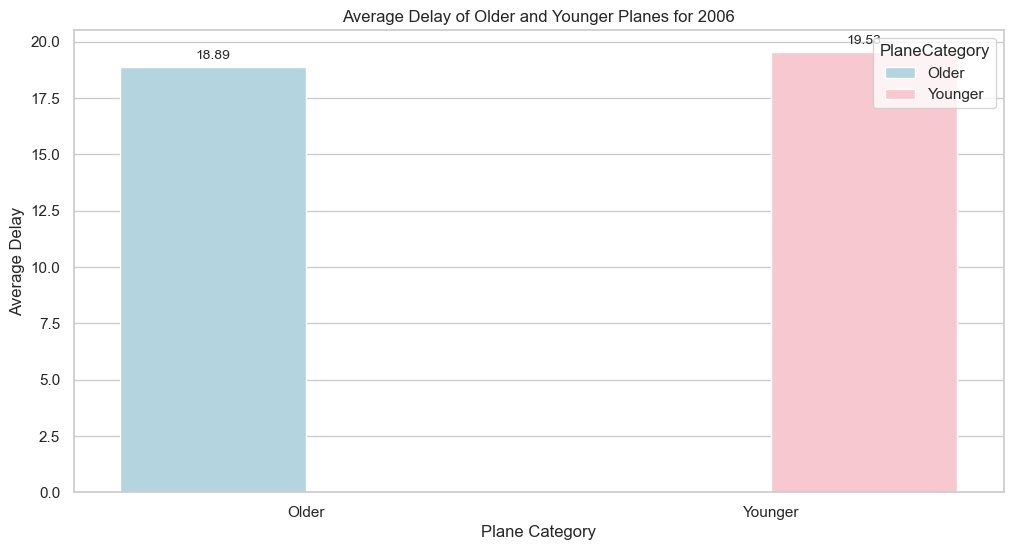

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  18.888175
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  19.529945


C:\Users\clare\New folder\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


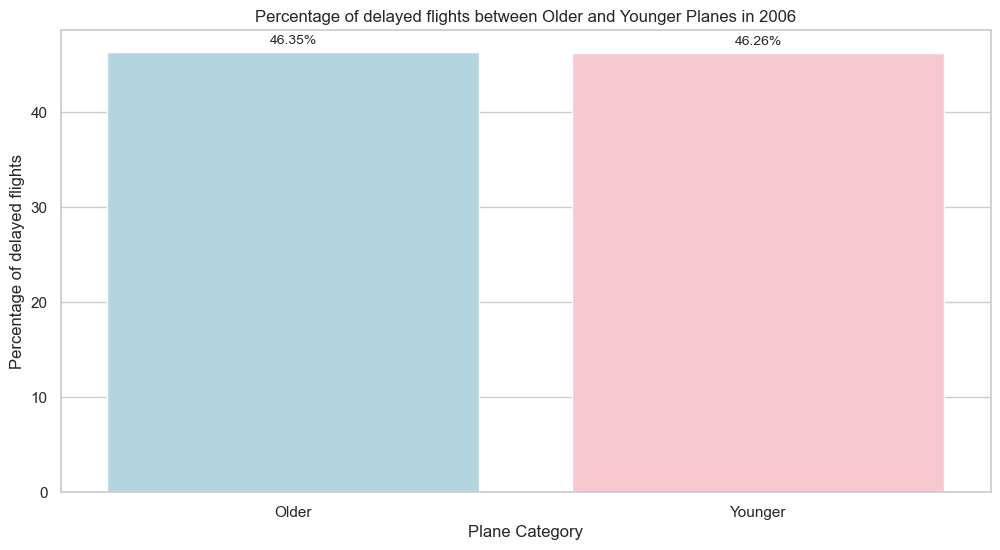

In [29]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

# Define the threshold age where usually > 20 is considered older but since there are no planes > 20, our threshold age will differ
threshold_age = 18

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2006'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2006')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2006')

# Show the plot
plt.show()

#### Younger planes experience higher average delay but in the % graph, younger planes have negligibly lower % of delayed flights
#### This results could be due to younger planes having lesser ontime flights or their earlier flights timings could be higher compared to those in older planes 

### 2007

In [30]:
df = pd.read_csv("2007.csv")

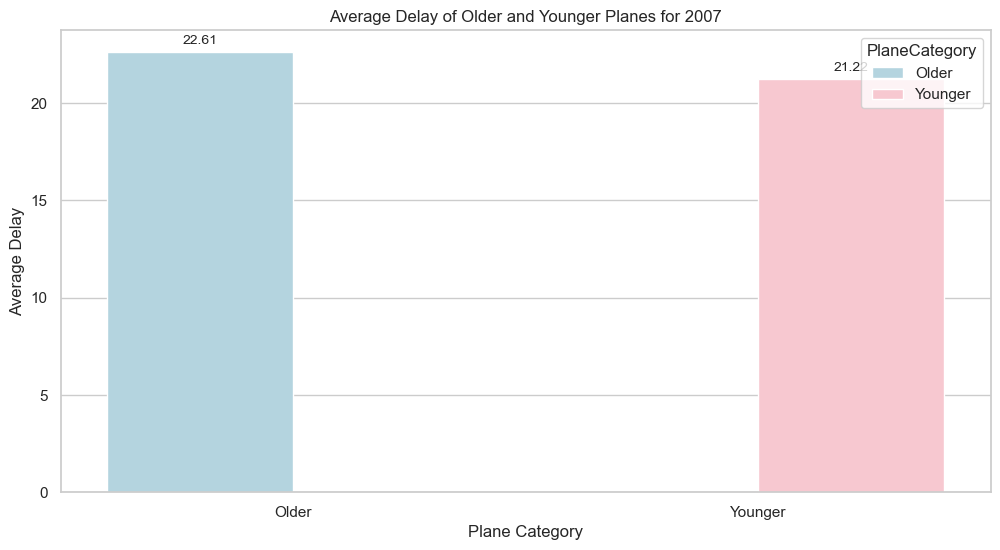

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  22.609579
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  21.215475


C:\Users\clare\New folder\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


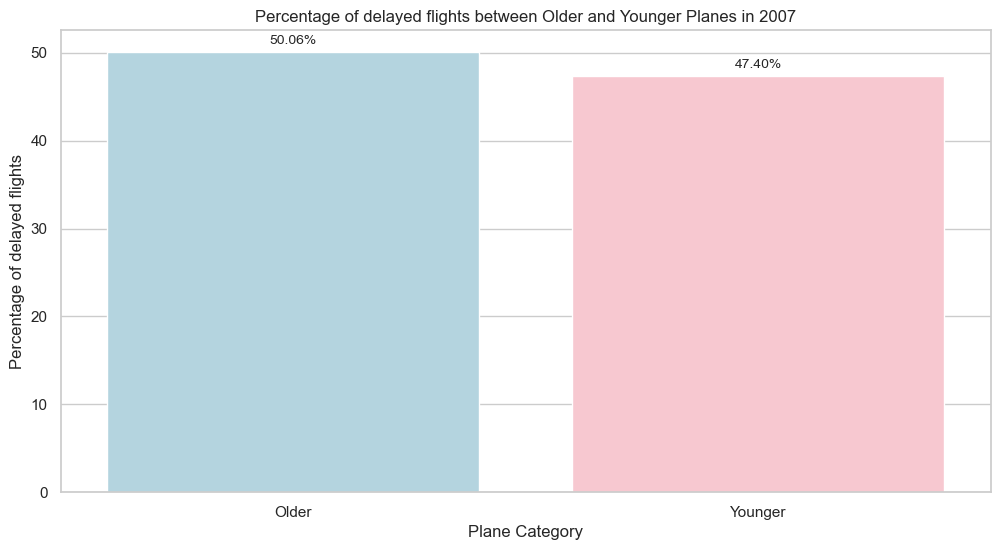

In [31]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Filter out invalid values in the 'year' column
plane_data = plane_data[plane_data['year'] != 0]

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')


# Filter out planes manufactured after 2007
plane_data = plane_data[plane_data['year'].dt.year <= 2007]

#calculating the age
plane_data['AgeAt2007'] = 2007 - plane_data['year'].dt.year

# Define the threshold age where usually > 20 is considered older 
threshold_age = 20

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2007'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2007')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2007')

# Show the plot
plt.show()

#### Older planes suffer more delays based on both in average delays and % of delayed flights, older planes have a higher value and %
#### However, in the % graph, older planes has about 3% more delayed flights but in average delay graph the difference is about 1.4 minutes. This could mean that even thought older planes have more % of delayed flights, their ontime flights or earlier flights are more or low enough respectively to get a lower average delay than what it should be. 

### 2008

In [38]:
df = pd.read_csv("2008.csv")

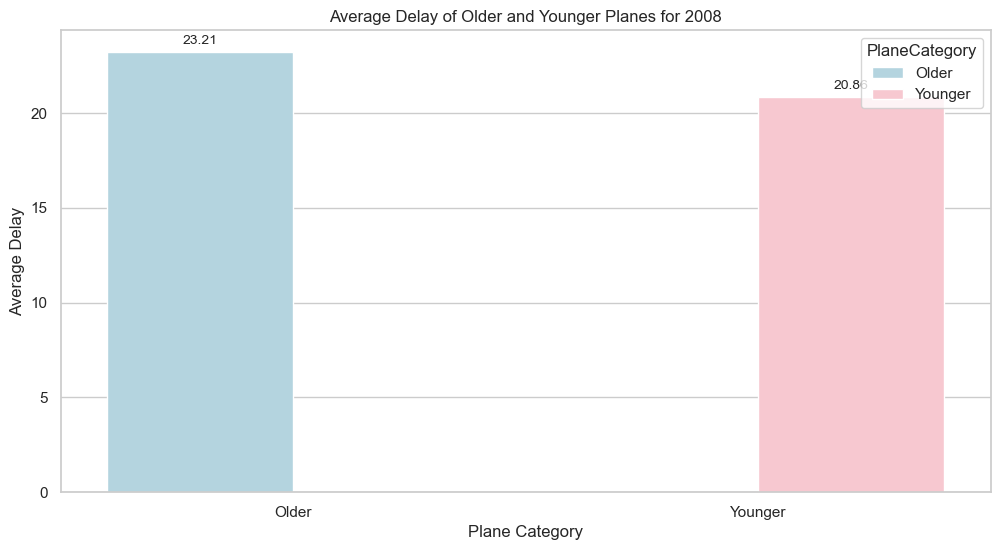

Average Delay of Older Planes:   PlaneCategory       mean
0         Older  23.205883
Average Delay of Younger Planes:   PlaneCategory       mean
0       Younger  20.861381


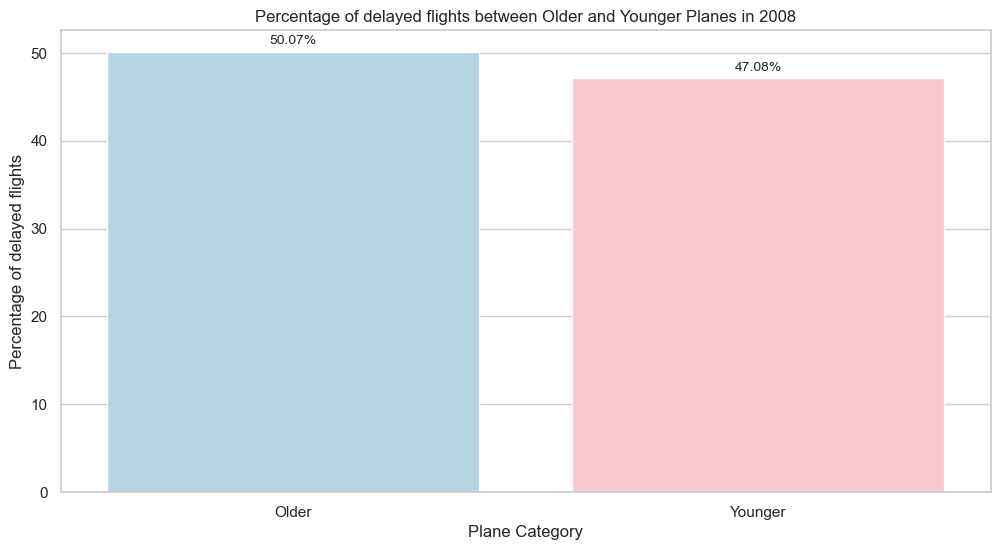

In [39]:
# filtering out cancelled and diverted flights i.e Diverted ==1 and Cancelled ==1 
df = df[(df['Diverted'] == 0) & (df['Cancelled'] == 0)]

plane_data = pd.read_csv("plane-data.csv")
from datetime import datetime

# Filter out invalid values in the 'year' column
plane_data = plane_data[plane_data['year'] != 0]

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')


# Filter out planes manufactured after 2008
plane_data = plane_data[plane_data['year'].dt.year <= 2008]

#calculating the age
plane_data['AgeAt2008'] = 2008 - plane_data['year'].dt.year

# Define the threshold age where usually > 20 is considered older 
threshold_age = 20

# Creation and Categorisation 
plane_data['PlaneCategory'] = 'Younger'  
plane_data.loc[plane_data['AgeAt2008'] >= threshold_age, 'PlaneCategory'] = 'Older'


# Renaming
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merging
merged_data = pd.merge(plane_data, df, on='TailNum', how='inner')

# Calculating total delays
merged_data['Delay'] = merged_data['ArrDelay'] + merged_data['DepDelay']

# Separation
older_planes = merged_data[merged_data['PlaneCategory'] == 'Older']
younger_planes = merged_data[merged_data['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index() 


# Ploting bar graph for avgdelays
import seaborn as sns

# Parameters
from matplotlib import rcParams 

rcParams['figure.figsize'] = 12,6

# Set the style of seaborn
sns.set(style="whitegrid") 

# Concatenate older and younger planes data
combined_planes_avgdelays = pd.concat([older_avgdelays, younger_avgdelays])

# Plotting the bar graph
graph = sns.barplot(data=combined_planes_avgdelays, x='PlaneCategory', y='mean', hue='PlaneCategory', palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add mean numbers on top of each bar
for bar in graph.patches:
    graph.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Average Delay')
plt.title('Average Delay of Older and Younger Planes for 2008')

# Show the plot
plt.show()

# Values
print("Average Delay of Older Planes:", older_avgdelays)
print("Average Delay of Younger Planes:", younger_avgdelays)


# Filter out flights with delays less than or equal to 0

older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
older_planes_with_delayed_flights = older_planes_with_delayed_flights['Delay'].count()
younger_planes_with_delayed_flights = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
older_planes_with_delayed_flights = (older_planes_with_delayed_flights / len(older_planes_cleaned)) * 100
younger_planes_with_delayed_flights = (younger_planes_with_delayed_flights / len(younger_planes_cleaned)) * 100

# Plotting the percentage of delayed flights older and younger planes
# Setting up the parameter 

rcParams['figure.figsize'] = 12,6


# Plotting the bar graph
bars = sns.barplot(x=['Older', 'Younger'], y=[older_planes_with_delayed_flights, younger_planes_with_delayed_flights], palette={'Older': 'lightblue', 'Younger': 'pink'})

# Add percentage numbers on top of each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f') + '%', 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

# Labelling and titles 
plt.xlabel('Plane Category')
plt.ylabel('Percentage of delayed flights')
plt.title('Percentage of delayed flights between Older and Younger Planes in 2008')

# Show the plot
plt.show()

#### Older planes experience higher average delays and this is supported by the % graph where older planes also experiences higher % in delayed flights 
#### The difference in % graph correlates to the difference in average delay graph as both has a difference of about 3% and 3 minutes respectively 

## Condensing 10 years of data into a pie chart. We are going to split it up into 2 groups. 1st overall average delay and 2nd % of delayed flights 

In [2]:
plane_data = pd.read_csv("plane-data.csv")

### 1st group : Overall average delay pie cahrt 

#### We first read the 10 years of data 

In [3]:
# Read 10 consecutive years of data

df99= pd.read_csv("1999.csv")
df00= pd.read_csv("2000.csv")
df01= pd.read_csv("2001.csv", encoding='iso-8859-1')
df02= pd.read_csv("2002.csv", encoding='iso-8859-1')
df03= pd.read_csv("2003.csv")
df04= pd.read_csv("2004.csv")
df05= pd.read_csv("2005.csv")
df06= pd.read_csv("2006.csv")
df07= pd.read_csv("2007.csv")
df08= pd.read_csv("2008.csv")

C:\Users\clare\AppData\Local\Temp\ipykernel_5188\4275039486.py:7: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df03= pd.read_csv("2003.csv.bz2")


#### We group all 10 years into 1 dataframe called dfs_total_1stpart.
#### While grouping, we also filter away diverted and cancelled flights and keep the interested columns that was recognised for the individual years codes 

In [4]:
# List of DataFrames with only specified columns and filtered for non-diverted and non-cancelled flights
dfs_total_1stpart = [
    df99[(df99['Diverted'] == 0) & (df99['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df00[(df00['Diverted'] == 0) & (df00['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df01[(df01['Diverted'] == 0) & (df01['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df02[(df02['Diverted'] == 0) & (df02['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df03[(df03['Diverted'] == 0) & (df03['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df04[(df04['Diverted'] == 0) & (df04['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df05[(df05['Diverted'] == 0) & (df05['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df06[(df06['Diverted'] == 0) & (df06['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df07[(df07['Diverted'] == 0) & (df07['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df08[(df08['Diverted'] == 0) & (df08['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']]
]

#### Manipulating the plane_data to prepare for merging with the dfs_total_1stpart that occurs at the end. Then end result would be in a list

In [5]:
# Filter out invalid values in the 'year' column
plane_data = plane_data[plane_data['year'] != 0]

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')

# Rename plane_data tailnum column into TailNum to be the same as the year's column name
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Merge plane_data with each DataFrame in dfs_total
dfs_total_1stpart_merged = [pd.merge(df, plane_data, on='TailNum', how='inner') for df in dfs_total_1stpart]

#### We concatenate the merged list into a single dataframe 

In [6]:
# Concatenate all merged lists in dfs_total_merged
df_combined_1stpart = pd.concat(dfs_total_1stpart_merged, ignore_index=True)
print(df_combined_1stpart)

          ArrDelay  DepDelay  Year TailNum         type manufacturer  \
0              4.0      -1.0  1999  N427US  Corporation       BOEING   
1              4.0       0.0  1999  N427US  Corporation       BOEING   
2             -6.0      -1.0  1999  N427US  Corporation       BOEING   
3              1.0      -9.0  1999  N427US  Corporation       BOEING   
4             13.0      -2.0  1999  N427US  Corporation       BOEING   
...            ...       ...   ...     ...          ...          ...   
35783067      19.0      12.0  2008  N37018  Corporation       BOEING   
35783068      -5.0      -2.0  2008  N77510  Corporation       BOEING   
35783069     -18.0      -4.0  2008  N77510  Corporation       BOEING   
35783070       0.0      -3.0  2008  N77510  Corporation       BOEING   
35783071       7.0      -1.0  2008  N77510  Corporation       BOEING   

          issue_date    model status            aircraft_type engine_type  \
0         07/15/2003  737-4B7  Valid  Fixed Wing Multi-Eng

### Unlike looking at individual years and their diff ages in each specific year, for the combined dataset we will take the latest year (2008) and use it to minus off the year the plane was used to get its age. Hence this combined 2 part data will differ from the individual year data 

In [7]:
# Drop rows with missing or invalid values in the 'year' column
df_combined_1stpart = df_combined_1stpart.dropna(subset=['year'])

# Convert 'year' column to integer representing the year
df_combined_1stpart['year'] = df_combined_1stpart['year'].dt.year.astype(int)

# Calculate the age of the planes based on the Year column
df_combined_1stpart['Age'] = 2008 - df_combined_1stpart['year']

# Assuming 'year' is the column you want to check for unique values
unique_years = df_combined_1stpart['year'].unique()
print(unique_years)


[1989 1990 1988 1987 1998 1996 1993 1994 1995 1997 1985 1984 1986 1991
 1992 1976 1973 1963 1967 2007 1974 1983 1982 1980 1968 1979 1962 1975
 1964 1959 1999 1969 1977 1970 1978 1971 1965 1972 2001 1956 2000 2002
 2003 1957 1966 2004 2005 2006 2008]


#### Define a set threshold age and then categorise the plane into older or younger based on its age calculated from the previous code 

In [8]:
# Define the threshold age where usually > 20 is considered older but since 2008 is the max year we are subtracting from we will have to adjust the threshold
threshold_age = 20

# Creation and Categorisation 
df_combined_1stpart['PlaneCategory'] = 'Younger'  
df_combined_1stpart.loc[df_combined_1stpart['Age'] >= threshold_age, 'PlaneCategory'] = 'Older'
print("Threshold Age:", threshold_age)

print(df_combined_1stpart['Age'].unique())


Threshold Age: 20
[19 18 20 21 10 12 15 14 13 11 23 24 22 17 16 32 35 45 41  1 34 25 26 28
 40 29 46 33 44 49  9 39 31 38 30 37 43 36  7 52  8  6  5 51 42  4  3  2
  0]


#### For the 10 years data, we will 1st be looking into the overall Delay ( ArrDelay + DepDelay)  without removing any ontime or earlier flights

In [9]:
# Calculating total delays
df_combined_1stpart['Delay'] = df_combined_1stpart['ArrDelay'] + df_combined_1stpart['DepDelay']

#### Separating the merged dataframe into 2 sub dataframes; older and younger 

In [10]:
# Separation
older_planes_1stpart = df_combined_1stpart[df_combined_1stpart['PlaneCategory'] == 'Older']
younger_planes_1stpart = df_combined_1stpart[df_combined_1stpart['PlaneCategory'] == 'Younger']
print("Number of older planes:", older_planes_1stpart.shape[0])
print("Number of younger planes:", younger_planes_1stpart.shape[0])


Number of older planes: 6185111
Number of younger planes: 26454434


#### We remove NaN values as a cautionary measure 
#### Next, we group and calculate the mean delay of each grouped dataframe 

In [11]:
# Cautionary cleaning 
older_planes_cleaned_1stpart = older_planes_1stpart.dropna(subset=['Delay'])
younger_planes_cleaned_1stpart = younger_planes_1stpart.dropna(subset=['Delay'])

# Group and aggregate average delays 
older_avgdelays = older_planes_cleaned_1stpart.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()
younger_avgdelays = younger_planes_cleaned_1stpart.groupby('PlaneCategory')['Delay'].agg(['mean']).reset_index()

#### Now that our dataframe is ready, we can now proceed to plotting it into a pie chart 

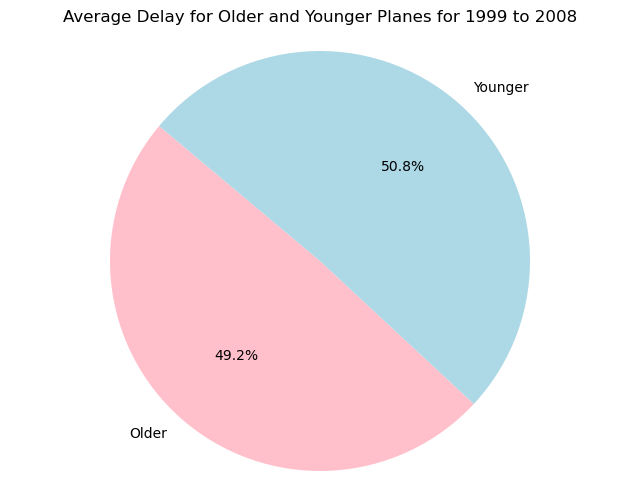

In [12]:
# Plotting a pie chart
import seaborn as sns

# Concatenate older and younger planes data
combined_planes_avgdelays_1stpart = pd.concat([older_avgdelays, younger_avgdelays])

# Data
categories = combined_planes_avgdelays_1stpart['PlaneCategory']
avg_delays = combined_planes_avgdelays_1stpart['mean']

# Colors for the slices
colors = ['pink', 'lightblue']

# Plot
plt.figure(figsize=(8, 6))
plt.pie(avg_delays, labels=categories, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Average Delay for Older and Younger Planes for 1999 to 2008')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Theres generally little to no difference between younger and older planes 
#### But to be more specific, younger planes suffer from more average delays by about 1 %

### 2nd part of the 10 year will be looking into % of delayed flights

In [2]:
# Re Read 10 consecutive years of data to make sure these dataframe hasnt been manipulated with

df99= pd.read_csv("1999.csv")
df00= pd.read_csv("2000.csv")
df01= pd.read_csv("2001.csv", encoding='iso-8859-1')
df02= pd.read_csv("2002.csv", encoding='iso-8859-1')
df03= pd.read_csv("2003.csv")
df04= pd.read_csv("2004.csv")
df05= pd.read_csv("2005.csv")
df06= pd.read_csv("2006.csv")
df07= pd.read_csv("2007.csv")
df08= pd.read_csv("2008.csv")

C:\Users\clare\AppData\Local\Temp\ipykernel_19016\2642026216.py:7: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df03= pd.read_csv("2003.csv.bz2")


#### We group all 10 years into 1 dataframe called dfs_total_2ndpart.
#### While grouping, we also filter away diverted and cancelled flights and keep the interested columns that was recognised for the individual years codes 

In [3]:
dfs_total_2ndpart = [

    df99[(df99['Diverted'] == 0) & (df99['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df00[(df00['Diverted'] == 0) & (df00['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df01[(df01['Diverted'] == 0) & (df01['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df02[(df02['Diverted'] == 0) & (df02['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df03[(df03['Diverted'] == 0) & (df03['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df04[(df04['Diverted'] == 0) & (df04['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df05[(df05['Diverted'] == 0) & (df05['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df06[(df06['Diverted'] == 0) & (df06['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df07[(df07['Diverted'] == 0) & (df07['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']],
    df08[(df08['Diverted'] == 0) & (df08['Cancelled'] == 0)][['ArrDelay', 'DepDelay', 'Year', 'TailNum']]
]

#### Reread the plane csv to remanipulate its data to prepare it for merging with dfs_total_2ndpart

In [13]:
# Re read the plane_data csv that hasnt been manipulated with 
plane_data = pd.read_csv("plane-data.csv")

# Filter out invalid values in the 'year' column
plane_data = plane_data[plane_data['year'] != 0]

# Convert 'year' column to proper datetime format
plane_data['year'] = pd.to_datetime(plane_data['year'], format='%Y')

# Rename plane_data tailnum column into TailNum to be the same as the year's column name
plane_data.rename(columns={'tailnum': 'TailNum' }, inplace=True)

# Filter out invalid values in the 'year' column
plane_data = plane_data[plane_data['year'] != 0]

# Merge plane_data with each DataFrame in dfs_total
dfs_total_2ndpart_merged = [pd.merge(df, plane_data, on='TailNum', how='inner') for df in dfs_total_2ndpart]

#### Making the lists into a single dataframe 

In [14]:
# Concatenate all merged DataFrames in dfs_total_merged
df_combined_2ndpart = pd.concat(dfs_total_2ndpart_merged, ignore_index=True)
print(df_combined_2ndpart)

          ArrDelay  DepDelay  Year TailNum         type manufacturer  \
0              4.0      -1.0  1999  N427US  Corporation       BOEING   
1              4.0       0.0  1999  N427US  Corporation       BOEING   
2             -6.0      -1.0  1999  N427US  Corporation       BOEING   
3              1.0      -9.0  1999  N427US  Corporation       BOEING   
4             13.0      -2.0  1999  N427US  Corporation       BOEING   
...            ...       ...   ...     ...          ...          ...   
35783067      19.0      12.0  2008  N37018  Corporation       BOEING   
35783068      -5.0      -2.0  2008  N77510  Corporation       BOEING   
35783069     -18.0      -4.0  2008  N77510  Corporation       BOEING   
35783070       0.0      -3.0  2008  N77510  Corporation       BOEING   
35783071       7.0      -1.0  2008  N77510  Corporation       BOEING   

          issue_date    model status            aircraft_type engine_type  \
0         07/15/2003  737-4B7  Valid  Fixed Wing Multi-Eng

#### Calculating the age of the plane using 2008 as the year to subtract from in general

In [15]:
# Drop rows with missing or invalid values in the 'year' column
df_combined_2ndpart = df_combined_2ndpart.dropna(subset=['year'])

# Convert 'year' column to integer representing the year
df_combined_2ndpart['year'] = df_combined_2ndpart['year'].dt.year.astype(int)

# Calculate the age of the planes based on the Year column
df_combined_2ndpart['Age'] = 2008 - df_combined_2ndpart['year']

# Assuming 'year' is the column you want to check for unique values
unique_years = df_combined_2ndpart['year'].unique()
print(unique_years)

[1989 1990 1988 1987 1998 1996 1993 1994 1995 1997 1985 1984 1986 1991
 1992 1976 1973 1963 1967 2007 1974 1983 1982 1980 1968 1979 1962 1975
 1964 1959 1999 1969 1977 1970 1978 1971 1965 1972 2001 1956 2000 2002
 2003 1957 1966 2004 2005 2006 2008]


#### Define the threshold and categorise the planes into older or younger based on the threshold

In [16]:
# Define the threshold age where usually > 20 is considered older
threshold_age = 20

# Creation and Categorisation 
df_combined_2ndpart['PlaneCategory'] = 'Younger'  
df_combined_2ndpart.loc[df_combined_2ndpart['Age'] >= threshold_age, 'PlaneCategory'] = 'Older'

#### In this section, we will only look into delayed flight and calculate its %. As such, after adding the ArrDelay and DepDelay into a new column called Delay, we filter to only keep Delays that are > 0 to remove ontime and earlier flights
#### Afterwards, we calculate the total number of flights (includes delayed, ontime and earlier flights) in both older and younger planes 
#### We then calcualte the % of flights that are delayed from the total number of flights 

In [19]:
# Calculating total delays for df_combined_2ndpart
df_combined_2ndpart['Delay'] = df_combined_2ndpart['ArrDelay'] + df_combined_2ndpart['DepDelay']

# Separation
older_planes = df_combined_2ndpart[df_combined_2ndpart['PlaneCategory'] == 'Older']
younger_planes = df_combined_2ndpart[df_combined_2ndpart['PlaneCategory'] == 'Younger']

# Cautionary cleaning 
older_planes_cleaned = older_planes.dropna(subset=['Delay'])
younger_planes_cleaned = younger_planes.dropna(subset=['Delay'])

# Filter out flights with delays less than or equal to 0 for older planes
older_planes_with_delayed_flights = older_planes_cleaned[older_planes_cleaned['Delay'] > 0]

# Filter out flights with delays less than or equal to 0 for younger planes
younger_planes_with_delayed_flights = younger_planes_cleaned[younger_planes_cleaned['Delay'] > 0]

# Calculate total delayed flights for older and younger planes (excluding non-positive delays)
total_delayed_older_planes = older_planes_with_delayed_flights['Delay'].count()
total_delayed_younger_planes = younger_planes_with_delayed_flights['Delay'].count()

# Calculate percentage of delayed flights
percentage_delayed_older_planes = (total_delayed_older_planes / len(older_planes_cleaned)) * 100
percentage_delayed_younger_planes = (total_delayed_younger_planes / len(younger_planes_cleaned)) * 100

print("Percentage of delayed flights in older planes:", percentage_delayed_older_planes)
print("Percentage of delayed flights in younger planes:", percentage_delayed_younger_planes)


Percentage of delayed flights in older planes: 44.915151886522324
Percentage of delayed flights in younger planes: 44.97141934586162


#### We finally plot the % calculated into a pie chart for easier visualisation 

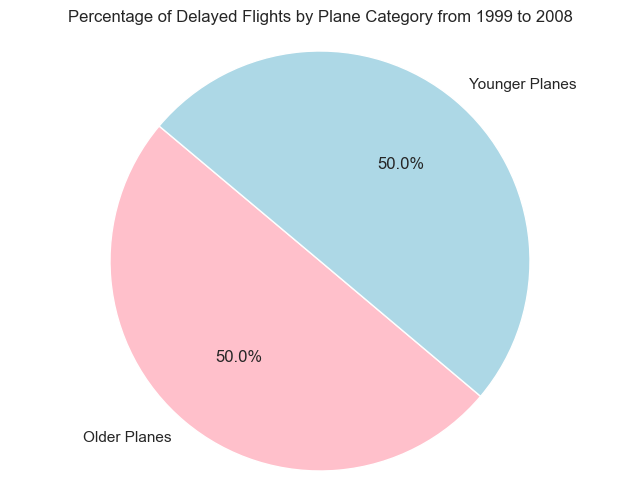

In [25]:
# Plotting a pie chart
import seaborn as sns

categories = ['Older Planes', 'Younger Planes']
percentages = [percentage_delayed_older_planes, percentage_delayed_younger_planes]

# Plotting the pie chart using Matplotlib
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140, colors=['pink', 'lightblue'])
plt.title('Percentage of Delayed Flights by Plane Category from 1999 to 2008')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### The graph shows that the % of delayed flights between older and younger planes are the same for 10 years of data combined. Hence older planes do not suffer more delays than younger planes